In [ ]:
%pylab inline

This notebook contains code to reproduce the following from Mitra, et al.:

* Extended Data Fig. 7: Allele frequency examples

In [1]:
# Input mutation results
MUTFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_GW_priors_Jan20/combined/SSC_allphases_011720_denovos_GW_priors_Jan20.final_qc_mutations.tab"
NAIVEMUTFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_naive_Jan20/SSC_allphases_011720_denovos_naive_Jan20.final_qc_mutations.tab"

# Make editable in Illustrator
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats
import statsmodels.api as sm
import seaborn as sns

# Color keys
colors = ['gray','red','gold','blue','green','purple','brown','salmon','magenta','cyan','darkblue']

# Other data paths
ANNOTFILE = "/storage/mgymrek/ssc-denovos/annotations/hg38_gangstr_MasterAnnotation-rmdup.bed"
AFREQFILE = "/storage/mgymrek/ssc-denovos/allele-freqs/SSC_merged_allele_counts.tab"
HETFILE = "/storage/mgymrek/ssc-denovos/allele-freqs/SSC_merged_het.tab"
AGEFILE = "/storage/ileena/denovos4/metadata/ssc_4phases_ages.csv"

# Output path info
OUTDIR = "pdfs/"

# Load expansions
ndata = pd.read_csv(NAIVEMUTFILE, sep="\t")
ndata = ndata[(ndata["posterior"]==-1) & (ndata["mutsize"]>=5)] # moderately big expansion events

# Filter ones that occur too many times
expcounts = ndata.groupby(["chrom","pos"], as_index=False).agg({"child": len})
ndata = pd.merge(ndata, expcounts[expcounts["child"]<=3][["chrom","pos"]], on=["chrom","pos"])

# Load main mutations data
alldata = pd.read_csv(MUTFILE, sep="\t")
usefams = set(alldata["family"])

# Concatenate expansions
ndata = ndata[ndata.family.isin(usefams)]
alldata = pd.concat([alldata, ndata])

# Manually remove problematic families. TODO add this instead to the QC script
# 14151 proband had 130 mutations
# other families have <20 in both proband and sibling
rmfams = [14151, 12434, 12281, 13673, 13351, 13355, 13143]
alldata = alldata[~alldata.family.isin(rmfams)]

# Load annotation info
annot = pd.read_csv(ANNOTFILE, sep="\t")

# Set up fields
def GetChrom(x):
    if "chr" in str(x): return int(x[3:])
    else: return int(x)
alldata["chrom"] = alldata["chrom"].apply(GetChrom)
annot = annot[annot["chrom"].apply(lambda x: x not in ["X","chrX","Y","chrY"])]
annot["chrom"] = annot["chrom"].apply(GetChrom)
annot["pos"] = annot["start"]

# Merge
adata = pd.merge(alldata, annot, on=["chrom","pos"])

AFREQFILE = "/storage/mgymrek/ssc-denovos/allele-freqs/SSC_merged_allele_counts.tab"
afreq = pd.read_csv(AFREQFILE, sep="\t")
afreq.columns = ["chrom","pos","newallele","count"]
afreq["chrom"] = afreq["chrom"].apply(GetChrom)

fdata = pd.merge(adata, afreq, on=["chrom","pos","newallele"], how="left")
fdata.ix[np.isnan(fdata["count"]),"count"] = 0

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


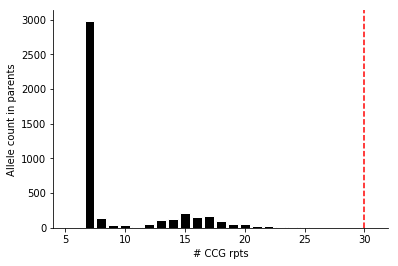

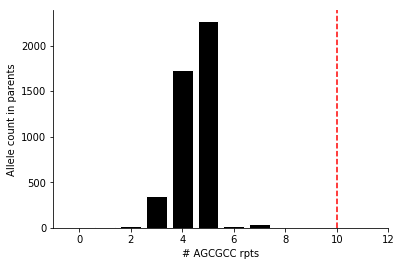

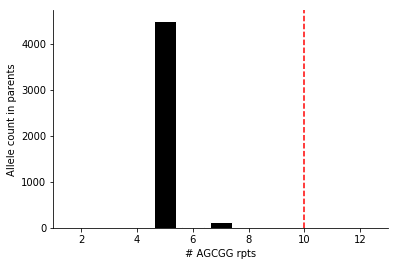

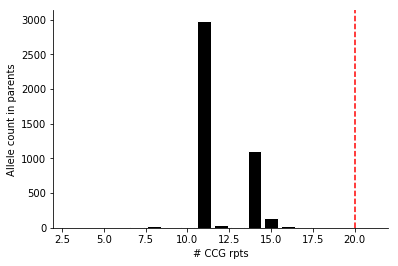

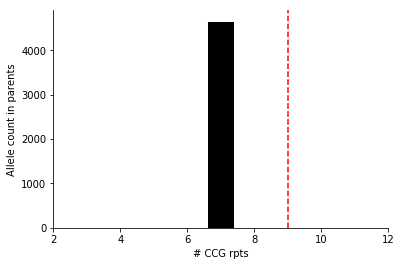

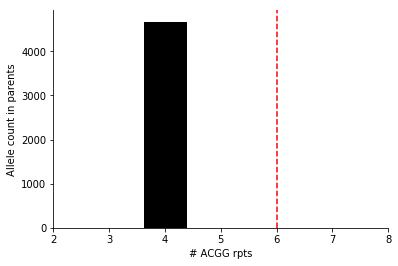

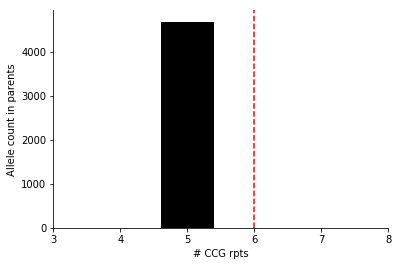

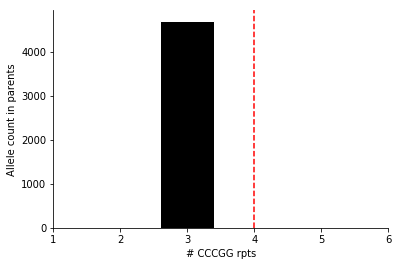

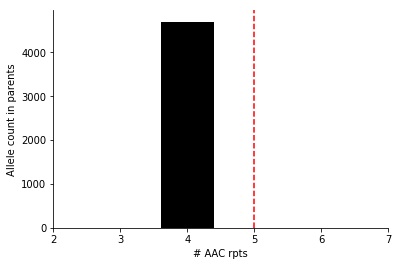

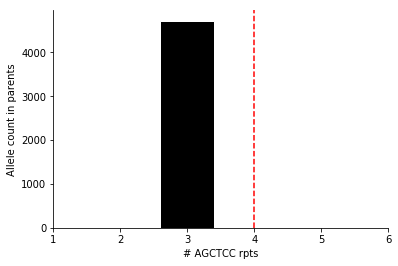

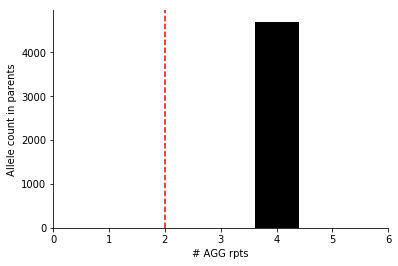

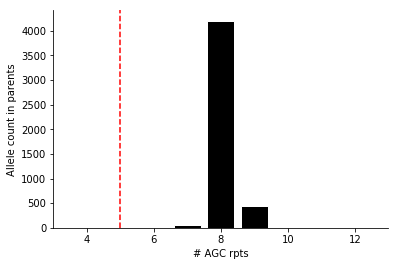

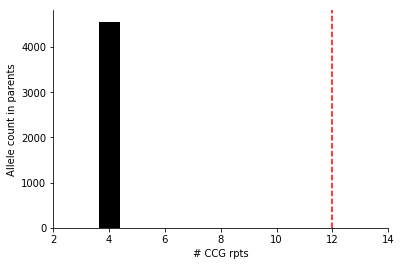

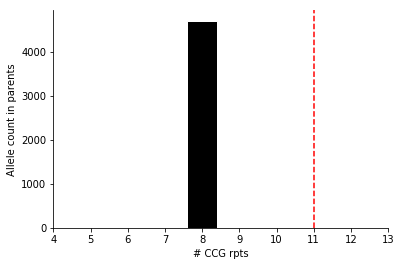

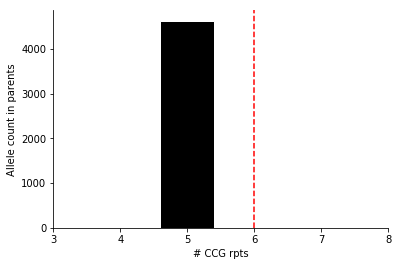

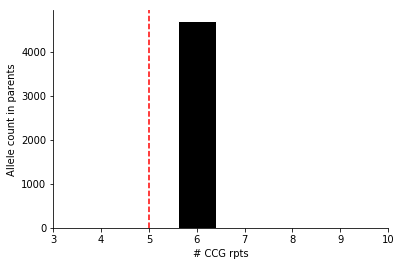

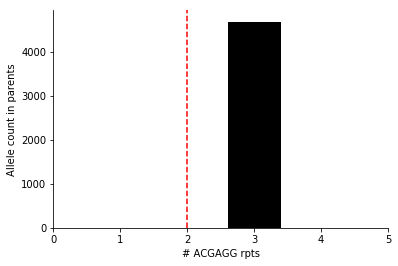

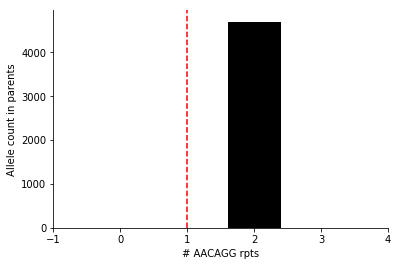

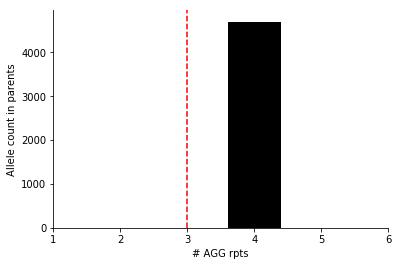

In [2]:
fdata[(fdata["phenotype"]==1) & (fdata["count"]==0) & 
      ((fdata["FEATURE-CODING"]>0) | (fdata["FEATURE-UTR5"]>0 | (fdata["FEATURE-PROMOTER5kb"]>0)))].sort_values("mutsize", ascending=False)[["chrom","pos","newallele","child_gt","mat_gt","pat_gt","gene-coding","TSS_GENE"]]

proband_pos = fdata[(fdata["phenotype"]==2) & (fdata["count"]==0) & 
      ((fdata["FEATURE-CODING"]>0) | (fdata["FEATURE-UTR5"]>0 | (fdata["FEATURE-PROMOTER5kb"]>0)))].sort_values("mutsize", ascending=False)["pos"]
sibling_pos = fdata[(fdata["phenotype"]==1) & (fdata["count"]==0) & 
      ((fdata["FEATURE-CODING"]>0) | (fdata["FEATURE-UTR5"]>0 | (fdata["FEATURE-PROMOTER5kb"]>0)))].sort_values("mutsize", ascending=False)["pos"]

for pos in list(proband_pos)+list(sibling_pos):
    freqs = afreq[afreq["pos"]==pos].copy()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(freqs["newallele"], freqs["count"], color="black", edgecolor="white");
    newallele = fdata[(fdata["pos"]==pos) & (fdata["count"]==0)]["newallele"].values[0]
    motif = fdata[(fdata["pos"]==pos)]["motif"].values[0]
    ax.axvline(x=newallele, linestyle="dashed", color="red")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom');
    ax.set_xlabel("# %s rpts"%motif)
    ax.set_ylabel("Allele count in parents")
    minallele = min([newallele]+list(freqs["newallele"]))
    maxallele = max([newallele]+list(freqs["newallele"]))
    ax.set_xlim(left=minallele-2, right=maxallele+2)
    if pos in list(proband_pos): name = "proband"
    else: name = "sibling"
    fig.savefig(os.path.join(OUTDIR, "SuppFig_%s_%s_AlleleCounts.pdf"%(pos, name)))